In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [3]:
online_sales=pd.read_csv("/content/Online_Sales.csv")
discount_coupon=pd.read_csv("/content/Discount_Coupon.csv")
tax_amount=pd.read_excel("/content/Tax_amount.xlsx")
customer_data=pd.read_excel("/content/CustomersData.xlsx")
marketing_spend=pd.read_csv("/content/Marketing_Spend.csv")




In [ ]:
# Merging CustomerData with Online_Sales on 'CustomerID' as a common key
merged_data = pd.merge(online_sales, customer_data, on='CustomerID', how='inner')

# Merging Discount_Coupon with merged_data on 'Product_Category'
merged_data = pd.merge(merged_data, discount_coupon[['Product_Category', 'Coupon_Code', 'Discount_pct']], on='Product_Category', how='left')

# Merging marketing_spend with merged_data on 'Transaction_Date'
merged_data = pd.merge(merged_data, marketing_spend, left_on='Transaction_Date', right_on='Date', how='left')

# Merging Tax_amount with merged_data on 'Product_Category'
merged_data = pd.merge(merged_data, tax_amount, on='Product_Category', how='left')



In [ ]:
# Convert 'Transaction_Date' to datetime
merged_data['Transaction_Date'] = pd.to_datetime(merged_data['Transaction_Date'])

# Create a new 'Month' column
merged_data['Month'] = merged_data['Transaction_Date'].dt.month


### 1. Calculate Invoice amount or sale_amount or revenue for each transaction and item level
 Invoice Value =(( Quantity*Avg_price)*(1-Dicount_pct)*(1+GST))+Delivery_Charges

In [ ]:
merged_data['Invoice_Value'] = ((merged_data['Quantity'] * merged_data['Avg_Price']) * (1 - merged_data['Discount_pct']) * (1 + merged_data['GST'])) + merged_data['Delivery_Charges']


In [ ]:
merged_data['Invoice_Value']

0         -1515.229
1         -3206.039
2         -4896.849
3         -1515.229
4         -3206.039
            ...    
630683    -6711.482
630684   -10254.362
630685    -3168.602
630686    -6711.482
630687   -10254.362
Name: Invoice_Value, Length: 630688, dtype: float64

## 2. Perform Detailed exploratory analysis

### Understanding how many customers acquired every month

In [ ]:
# Extract month and year from Transaction_Date
merged_data['Transaction_Date'] = pd.to_datetime(merged_data['Transaction_Date'])
merged_data['YearMonth'] = merged_data['Transaction_Date'].dt.to_period('M')

# Group by month and count unique customers
new_customers_by_month = merged_data.groupby('YearMonth')['CustomerID'].nunique()


In [ ]:
print("Number of New Customers Acquired Each Month:")
print(new_customers_by_month)

Number of New Customers Acquired Each Month:

YearMonth

2019-01    215

2019-02    109

2019-03    208

2019-04    224

2019-05    200

2019-06    259

2019-07    236

2019-08    300

2019-09    193

2019-10    210

2019-11    188

2019-12    236

Freq: M, Name: CustomerID, dtype: int64


### Understand the retention of customers on month on month basis

C:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.

  fig.canvas.print_figure(bytes_io, **kw)


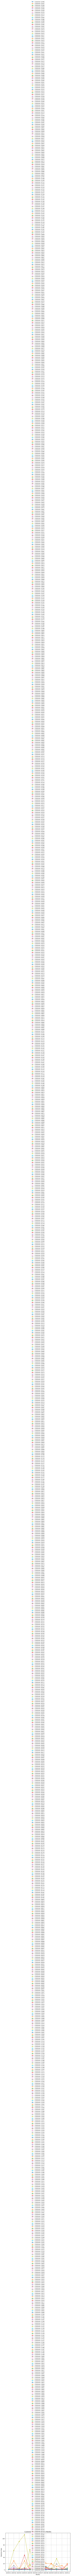

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'Transaction_Date' to datetime
merged_data['Transaction_Date'] = pd.to_datetime(merged_data['Transaction_Date'])

# Extract Year and Month from 'Transaction_Date'
merged_data['YearMonth'] = merged_data['Transaction_Date'].dt.to_period('M')

# Create a pivot table to determine the number of customers in each month
pivot_table = pd.pivot_table(merged_data, index='CustomerID', columns='YearMonth',
                             values='Transaction_Date', aggfunc='count', fill_value=0)

# Calculate the number of customers in the first month
initial_customers = pivot_table.iloc[:, 0]

# Calculate customer retention for each month
retention_rate = pivot_table.divide(initial_customers, axis=0)

# Convert 'YearMonth' to string for plotting
retention_rate.columns = retention_rate.columns.strftime('%Y-%m')

# Plot the customer retention rate
plt.figure(figsize=(10, 6))
plt.title('Customer Retention Rate Over Months')
plt.xlabel('Months')
plt.ylabel('Retention Rate')
for customer_id, row in retention_rate.iterrows():
    plt.plot(row.index, row.values, marker='o', label=f'Customer {customer_id}')

plt.legend()
plt.grid(True)
plt.show()


### How the revenues from existing/new customers on month on month basis

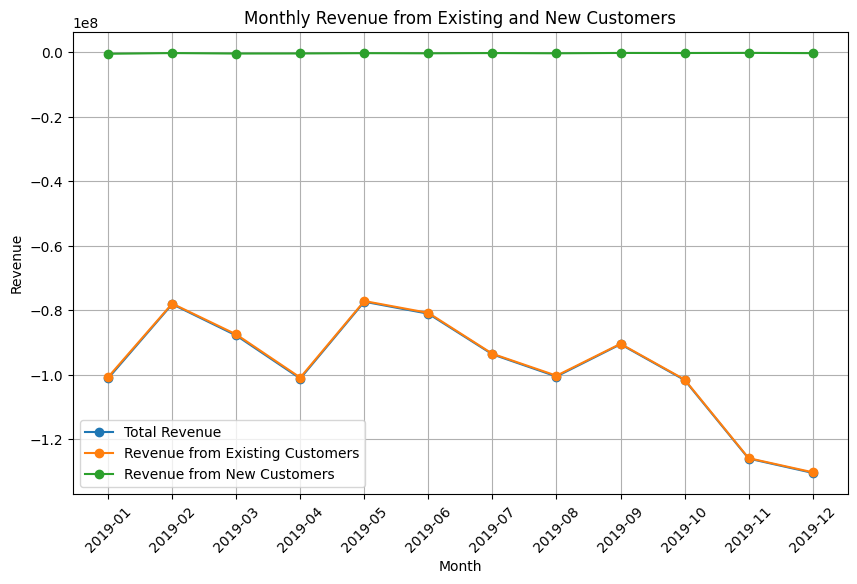

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'Transaction_Date' to datetime
merged_data['Transaction_Date'] = pd.to_datetime(merged_data['Transaction_Date'])

# Extract Year and Month from 'Transaction_Date' to create the 'YearMonth' column
merged_data['YearMonth'] = merged_data['Transaction_Date'].dt.to_period('M')

# Calculate Monthly Revenue
monthly_revenue = merged_data.groupby('YearMonth')['Invoice_Value'].sum()

# Identify New Customers
first_purchase_dates = merged_data.groupby('CustomerID')['YearMonth'].min()
new_customers = first_purchase_dates.groupby(first_purchase_dates).count()

# Segregate Revenue
revenue_existing_customers = monthly_revenue - new_customers * merged_data['Invoice_Value'].mean()
revenue_new_customers = new_customers * merged_data['Invoice_Value'].mean()

# Create a DataFrame for analysis
revenue_data = pd.DataFrame({
    'Month': monthly_revenue.index.strftime('%Y-%m'),
    'Total Revenue': monthly_revenue,
    'Revenue from Existing Customers': revenue_existing_customers,
    'Revenue from New Customers': revenue_new_customers
})

# Plot the Data
plt.figure(figsize=(10, 6))
plt.title('Monthly Revenue from Existing and New Customers')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.plot(revenue_data['Month'], revenue_data['Total Revenue'], label='Total Revenue', marker='o')
plt.plot(revenue_data['Month'], revenue_data['Revenue from Existing Customers'], label='Revenue from Existing Customers', marker='o')
plt.plot(revenue_data['Month'], revenue_data['Revenue from New Customers'], label='Revenue from New Customers', marker='o')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [ ]:
print("Revenue from New Customers:")
print(revenue_new_customers)

Revenue from New Customers:

YearMonth

2019-01   -398651.248797

2019-02   -178002.418067

2019-03   -328191.958312

2019-04   -302233.272344

2019-05   -207669.487745

2019-06   -254024.284117

2019-07   -174294.034358

2019-08   -250315.900407

2019-09   -144626.964680

2019-10   -161314.691374

2019-11   -126085.046131

2019-12   -196544.336616

Freq: M, Name: YearMonth, dtype: float64


### How the discounts playing role in the revenues?

In [ ]:
#Calculate the "Discount Amount" for each transaction
merged_data['Discount_Amount'] = (merged_data['Quantity'] * merged_data['Avg_Price']) * (merged_data['Discount_pct'] / 100)


In [ ]:
#Calculate the "Effective Revenue" for each transaction, which takes discounts into account.
merged_data['Effective_Revenue'] = (merged_data['Quantity'] * merged_data['Avg_Price']) - merged_data['Discount_Amount']


In [ ]:
#Group the data by month and calculate the total revenue and total discount amount for each month.
monthly_revenue = merged_data.groupby('YearMonth')['Effective_Revenue'].sum()
monthly_discount = merged_data.groupby('YearMonth')['Discount_Amount'].sum()


In [ ]:
#Calculate the "Net Revenue" for each month, which is the total revenue minus the total discount amount.
monthly_net_revenue = monthly_revenue - monthly_discount


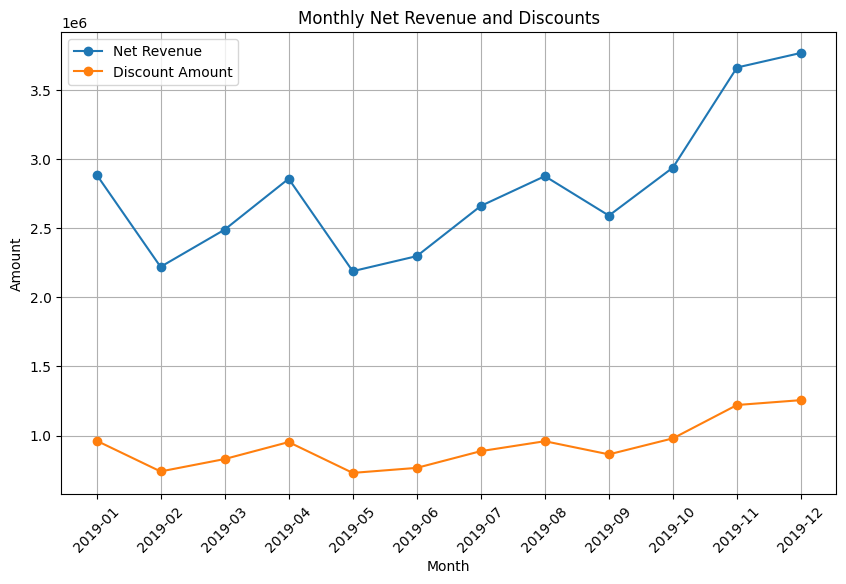

In [ ]:
#Plot the data to visualize the relationship between discounts and revenues.

plt.figure(figsize=(10, 6))
plt.title('Monthly Net Revenue and Discounts')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.plot(monthly_net_revenue.index.strftime('%Y-%m'), monthly_net_revenue, label='Net Revenue', marker='o')
plt.plot(monthly_discount.index.strftime('%Y-%m'), monthly_discount, label='Discount Amount', marker='o')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


###  Analyse KPI’s like Revenue, number of orders, average order value, number of customers (existing/new), quantity, by category, by month, by week, by day etc…

In [ ]:
#onthly revenue:

monthly_revenue = merged_data.groupby('YearMonth')['Invoice_Value'].sum()


In [ ]:
#monthly number of orders:
monthly_orders = merged_data.groupby('YearMonth')['Transaction_ID'].nunique()


In [ ]:
#monthly average order value:
monthly_avg_order_value = monthly_revenue / monthly_orders


In [ ]:
# Convert 'Transaction_Date' to a datetime object
merged_data['Transaction_Date'] = pd.to_datetime(merged_data['Transaction_Date'])

# Extract year and month from 'Transaction_Date'
merged_data['YearMonth'] = merged_data['Transaction_Date'].dt.to_period('M')

# Calculate new customers
first_purchase_dates = merged_data.groupby('CustomerID')['YearMonth'].min()
new_customers = first_purchase_dates.groupby(first_purchase_dates).count()


In [ ]:
# Quantity Analysis:

monthly_quantity = merged_data.groupby('YearMonth')['Quantity'].sum()


In [ ]:
#By Category Analysis:
monthly_revenue_by_category = merged_data.groupby(['YearMonth', 'Product_Category'])['Invoice_Value'].sum()


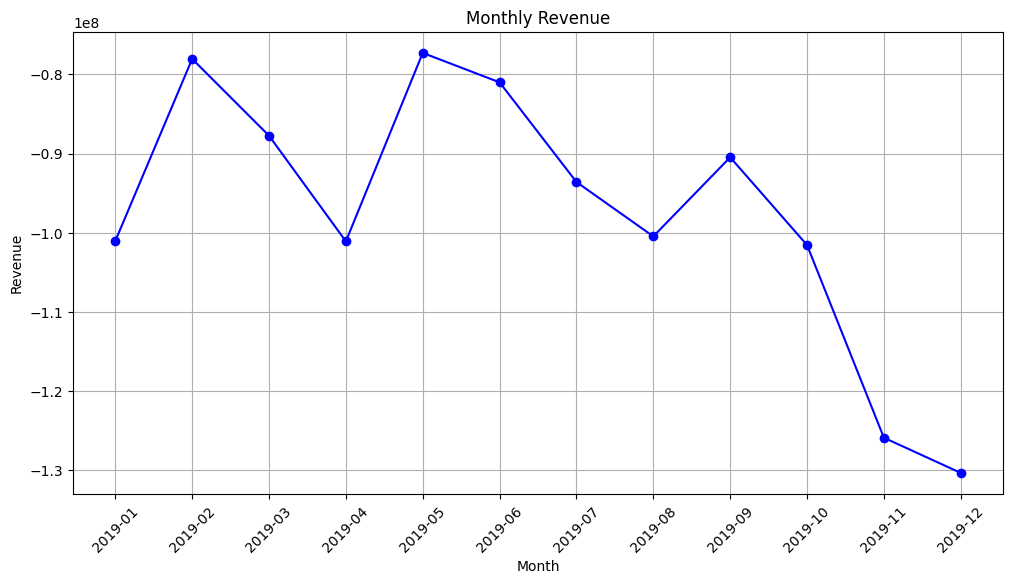

In [ ]:
# Visualization


# Convert Period to string for plotting
monthly_revenue.index = monthly_revenue.index.strftime('%Y-%m')

# Plot Monthly Revenue
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker='o', linestyle='-', color='b')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True)
plt.show()




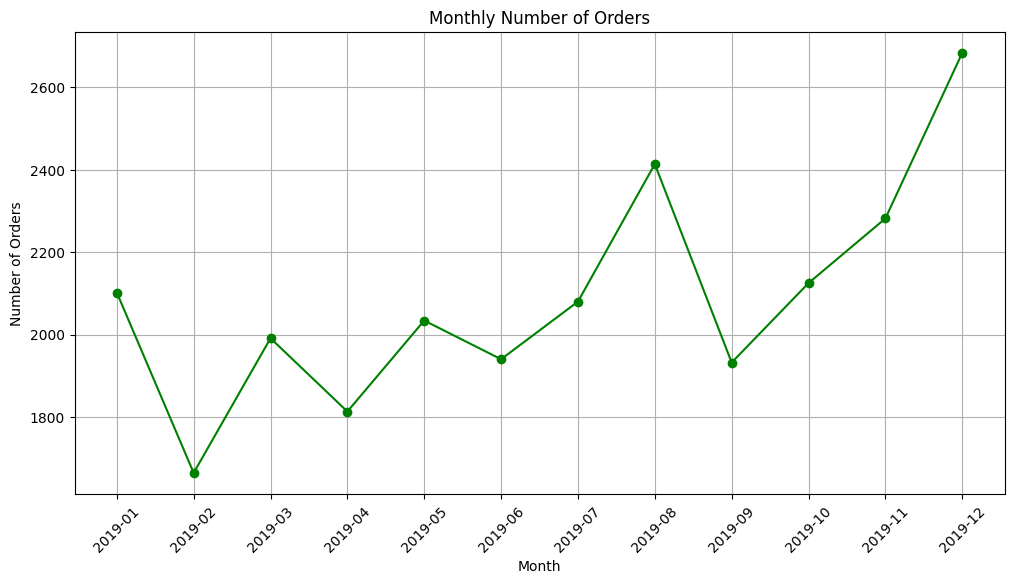

In [ ]:
# Convert Period to string for plotting
monthly_orders.index = monthly_orders.index.strftime('%Y-%m')

# Plot Monthly Number of Orders
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders.index, monthly_orders.values, marker='o', linestyle='-', color='g')
plt.title('Monthly Number of Orders')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True)
plt.show()


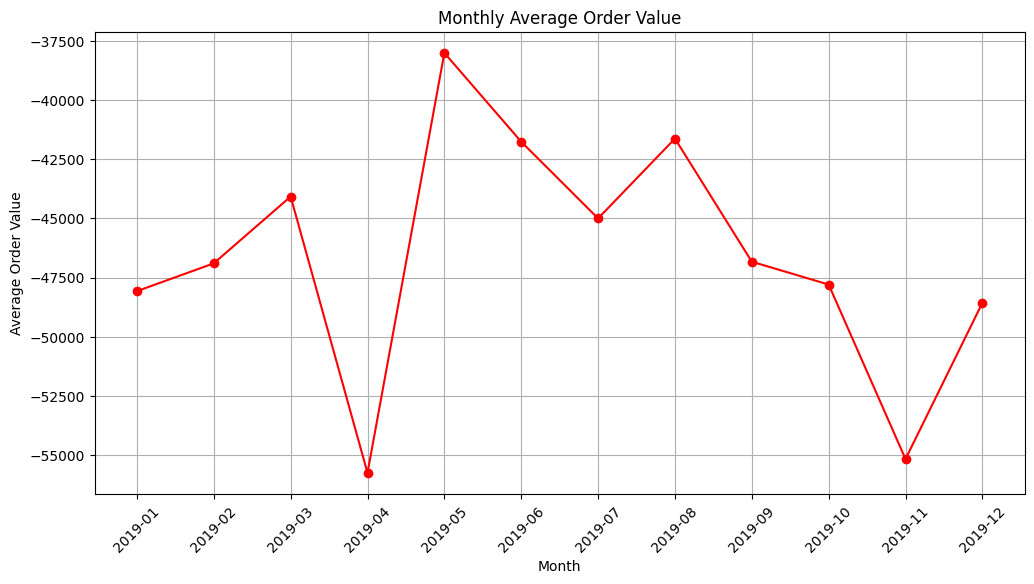

In [ ]:
# Convert Period to string for plotting
monthly_avg_order_value.index = monthly_avg_order_value.index.strftime('%Y-%m')

# Plot Monthly Average Order Value
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_order_value.index, monthly_avg_order_value.values, marker='o', linestyle='-', color='r')
plt.title('Monthly Average Order Value')
plt.xlabel('Month')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True)
plt.show()


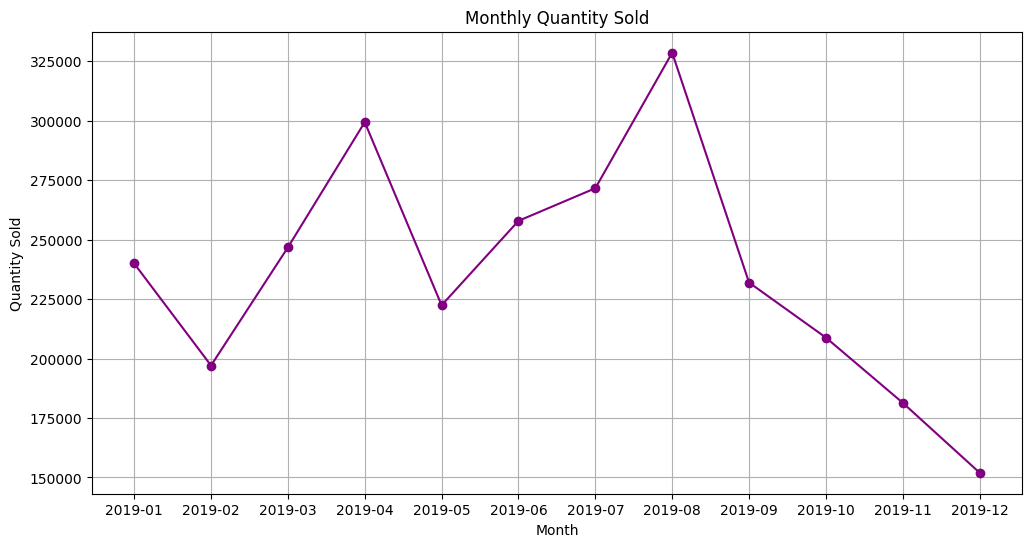

In [ ]:
# Convert Period objects to strings
monthly_quantity.index = monthly_quantity.index.astype(str)

# Plot Monthly Quantity Sold
plt.figure(figsize=(12, 6))
plt.plot(monthly_quantity.index, monthly_quantity.values, marker='o', linestyle='-', color='purple')
plt.title('Monthly Quantity Sold')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()


### Understand the trends/seasonality of sales by category, location, month etc…


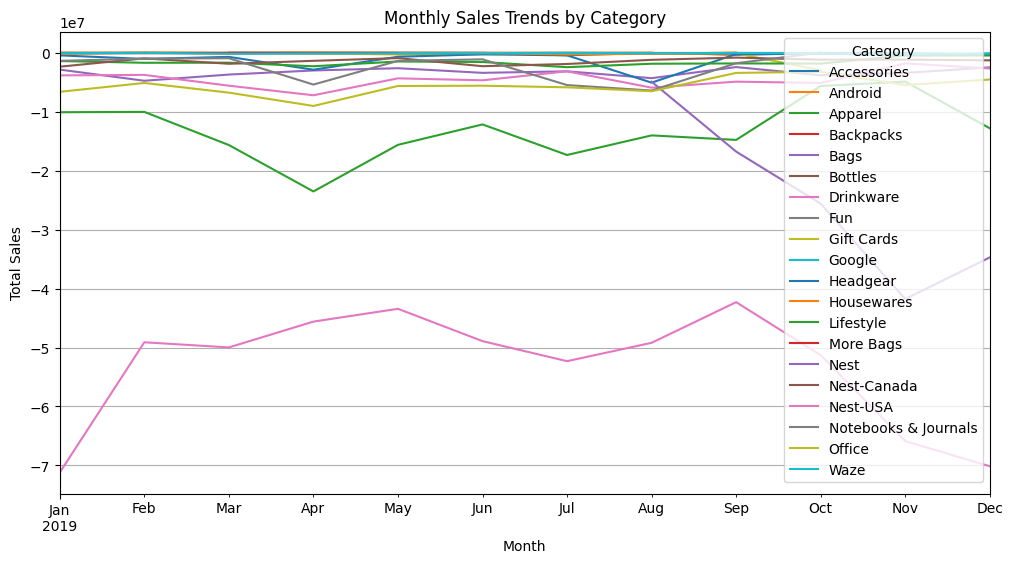

In [ ]:

# Sales Trends by Category
category_sales = merged_data.groupby(['YearMonth', 'Product_Category'])['Invoice_Value'].sum().unstack()
category_sales.plot(figsize=(12, 6))
plt.title('Monthly Sales Trends by Category')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Category')
plt.grid(True)
plt.show()



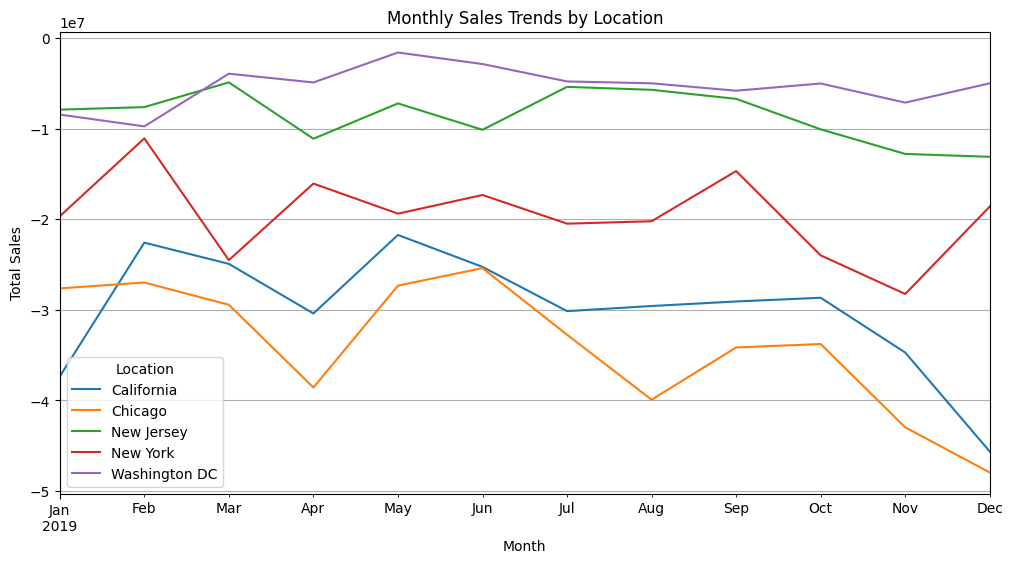

In [ ]:
# Sales Trends by Location
location_sales = merged_data.groupby(['YearMonth', 'Location'])['Invoice_Value'].sum().unstack()
location_sales.plot(figsize=(12, 6))
plt.title('Monthly Sales Trends by Location')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Location')
plt.grid(True)
plt.show()


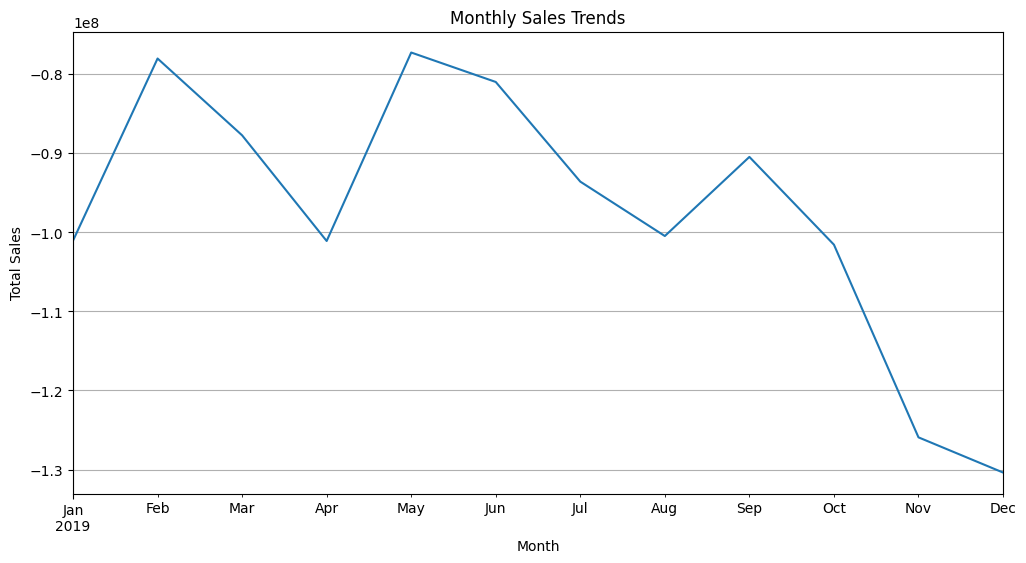

In [ ]:

# Monthly Sales Trends
monthly_sales = merged_data.groupby('YearMonth')['Invoice_Value'].sum()
monthly_sales.plot(figsize=(12, 6))
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()



### How number order varies and sales with different days?


In [ ]:
# Extract day of the week
merged_data['Date'] = pd.to_datetime(merged_data['Date'])  # Replace 'Date' with the actual column name
merged_data['DayOfWeek'] = merged_data['Date'].dt.day_name()


In [ ]:
merged_data['DayOfWeek']

0         Tuesday
1         Tuesday
2         Tuesday
3         Tuesday
4         Tuesday
           ...   
630683    Tuesday
630684    Tuesday
630685    Tuesday
630686    Tuesday
630687    Tuesday
Name: DayOfWeek, Length: 630688, dtype: object

In [ ]:
merged_data.head()

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679       2019-01-01  GGOENEBJ079499   
1       17850           16679       2019-01-01  GGOENEBJ079499   
2       17850           16679       2019-01-01  GGOENEBJ079499   
3       17850           16679       2019-01-01  GGOENEBJ079499   
4       17850           16679       2019-01-01  GGOENEBJ079499   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
3  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
4  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  ...       Date  \
0         1     153.71               6.5          Used  ... 2019-01-01   
1         1     153.71               6.5          Used  ... 2019-01-01   
2         1     153.71               6.5          Used  ... 2019-01-01   
3         1     153.71               6.5          Used  ... 2019-01-01   
4         1     153.71               6.5          Used  ... 2019-01-01   

  Offline_Spend  Online_Spend  GST  Month Invoice_Value  YearMonth  \
0          4500        2424.5  0.1      1     -1515.229    2019-01   
1          4500        2424.5  0.1      1     -3206.039    2019-01   
2          4500        2424.5  0.1      1     -4896.849    2019-01   
3          4500        2424.5  0.1      1     -1515.229    2019-01   
4          4500        2424.5  0.1      1     -3206.039    2019-01   

   Discount_Amount  Effective_Revenue  DayOfWeek  
0           15.371            138.339    Tuesday  
1           30.742            122.968    Tuesday  
2           46.113            107.597    Tuesday  
3           15.371            138.339    Tuesday  
4           30.742            122.968    Tuesday  

[5 rows x 25 columns]

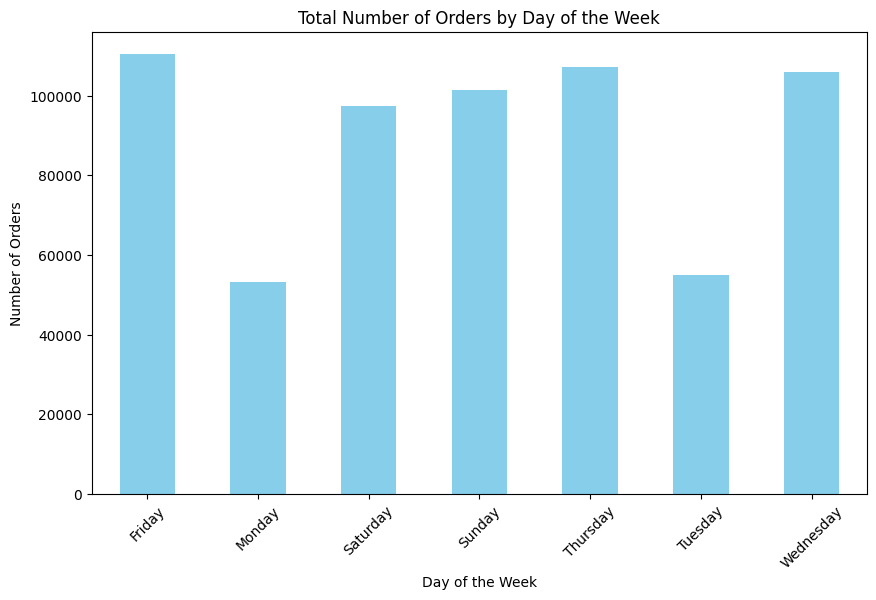

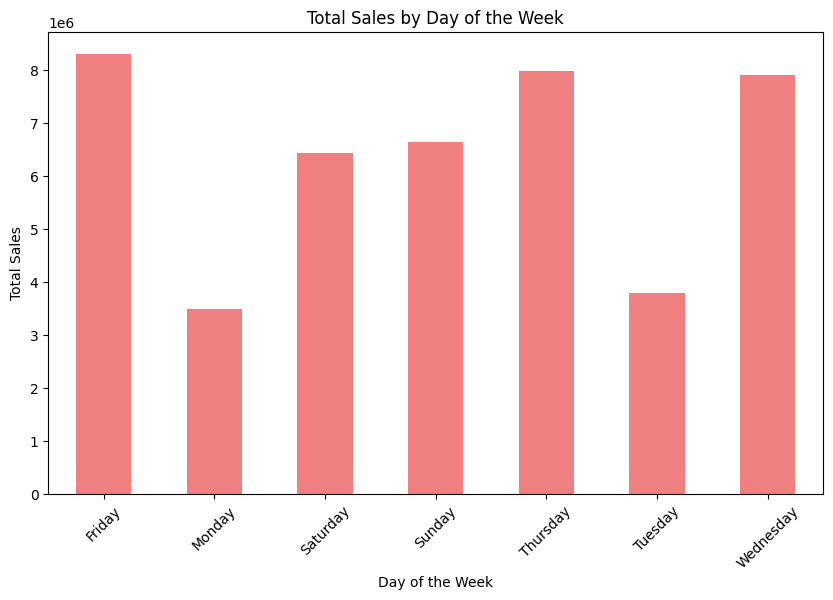

In [ ]:
# Group the data by 'DayOfWeek' and calculate total orders and sales
daily_orders = merged_data.groupby('DayOfWeek')['Transaction_ID'].count()
daily_sales = merged_data.groupby('DayOfWeek')['Effective_Revenue'].sum()

# Plot the variations
import matplotlib.pyplot as plt

# Plot the total number of orders by day
plt.figure(figsize=(10, 6))
daily_orders.plot(kind='bar', color='skyblue')
plt.title('Total Number of Orders by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

# Plot the total sales by day
plt.figure(figsize=(10, 6))
daily_sales.plot(kind='bar', color='lightcoral')
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


### Calculate the Revenue, Marketing spend, percentage of marketing spend out of revenue, Tax, percentage of delivery charges by month.


In [ ]:


# Convert 'Transaction_Date' to a datetime object
merged_data['Transaction_Date'] = pd.to_datetime(merged_data['Transaction_Date'])

# Extract the year and month from the 'Transaction_Date'
merged_data['YearMonth'] = merged_data['Transaction_Date'].dt.strftime('%Y-%m')

# Group the data by month and calculate totals
monthly_totals = merged_data.groupby('YearMonth').agg({
    'Effective_Revenue': 'sum',
    'Online_Spend': 'sum',
    'GST': 'sum',
    'Delivery_Charges': 'sum'
}).reset_index()


# Calculate the percentage of marketing spend out of revenue
monthly_totals['Marketing_Spend_Percentage'] = (monthly_totals['Online_Spend'] / monthly_totals['Effective_Revenue']) * 100


# Calculate the percentage of delivery charges out of revenue
monthly_totals['Delivery_Charges_Percentage'] = (monthly_totals['Delivery_Charges'] / monthly_totals['Effective_Revenue']) * 100

# Display the resulting DataFrame
print(monthly_totals)


   YearMonth  Effective_Revenue  Online_Spend       GST  Delivery_Charges  \

0    2019-01        3850126.368  9.141450e+07   6362.64         701661.57   

1    2019-02        2959907.040  7.557066e+07   5305.26         582213.68   

2    2019-03        3318592.608  8.265592e+07   7302.36         713367.13   

3    2019-04        3809704.032  9.727013e+07   7014.24         491709.32   

4    2019-05        2917985.088  8.985455e+07   7864.04         489602.06   

5    2019-06        3063184.800  8.855685e+07   7153.04         445127.82   

6    2019-07        3547330.464  1.077274e+08   9037.22         576989.36   

7    2019-08        3834681.888  1.377828e+08  10900.64         727644.57   

8    2019-09        3454053.504  8.815646e+07   7140.30         489388.08   

9    2019-10        3917566.752  9.352580e+07   6483.26         550056.79   

10   2019-11        4882393.536  1.071531e+08   5529.52         387479.16   

11   2019-12        5023278.624  1.349328e+08   6586.56         

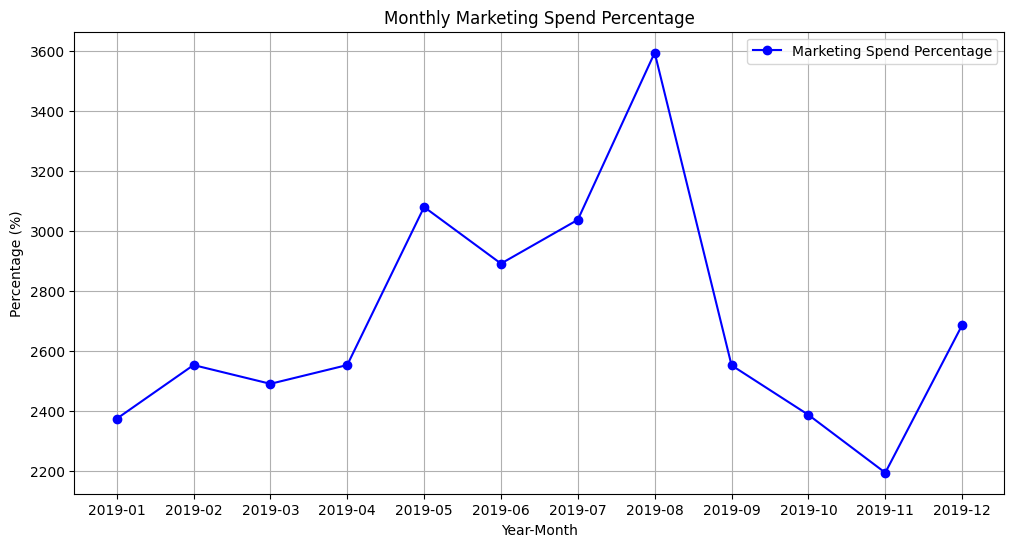

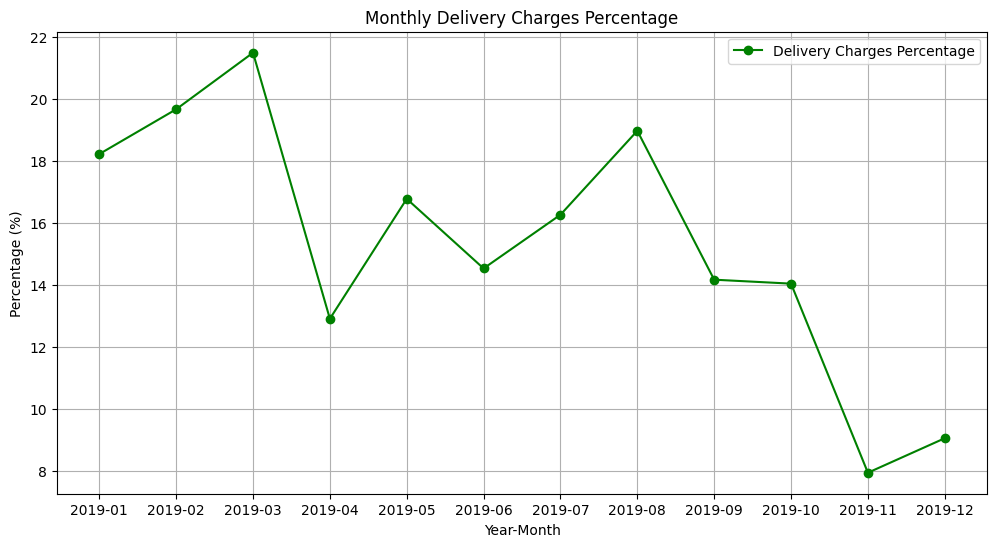

In [ ]:
# Plot the Marketing Spend Percentage
plt.figure(figsize=(12, 6))
plt.plot(monthly_totals['YearMonth'], monthly_totals['Marketing_Spend_Percentage'], marker='o', linestyle='-', color='blue', label='Marketing Spend Percentage')
plt.title('Monthly Marketing Spend Percentage')
plt.xlabel('Year-Month')
plt.ylabel('Percentage (%)')
plt.grid(True)
plt.legend()

# Plot the Delivery Charges Percentage
plt.figure(figsize=(12, 6))
plt.plot(monthly_totals['YearMonth'], monthly_totals['Delivery_Charges_Percentage'], marker='o', linestyle='-', color='green', label='Delivery Charges Percentage')
plt.title('Monthly Delivery Charges Percentage')
plt.xlabel('Year-Month')
plt.ylabel('Percentage (%)')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
# Display the monthly_totals DataFrame
print(monthly_totals)

   YearMonth  Effective_Revenue  Online_Spend       GST  Delivery_Charges  \

0    2019-01        3850126.368  9.141450e+07   6362.64         701661.57   

1    2019-02        2959907.040  7.557066e+07   5305.26         582213.68   

2    2019-03        3318592.608  8.265592e+07   7302.36         713367.13   

3    2019-04        3809704.032  9.727013e+07   7014.24         491709.32   

4    2019-05        2917985.088  8.985455e+07   7864.04         489602.06   

5    2019-06        3063184.800  8.855685e+07   7153.04         445127.82   

6    2019-07        3547330.464  1.077274e+08   9037.22         576989.36   

7    2019-08        3834681.888  1.377828e+08  10900.64         727644.57   

8    2019-09        3454053.504  8.815646e+07   7140.30         489388.08   

9    2019-10        3917566.752  9.352580e+07   6483.26         550056.79   

10   2019-11        4882393.536  1.071531e+08   5529.52         387479.16   

11   2019-12        5023278.624  1.349328e+08   6586.56         

### How marketing spend is impacting on revenue?

In [ ]:
# Calculate the correlation between marketing spend and revenue
correlation = monthly_totals['Online_Spend'].corr(monthly_totals['Effective_Revenue'])

# Print the correlation coefficient
print("Correlation between Marketing Spend and Revenue:", correlation)


Correlation between Marketing Spend and Revenue: 0.6809812274604146


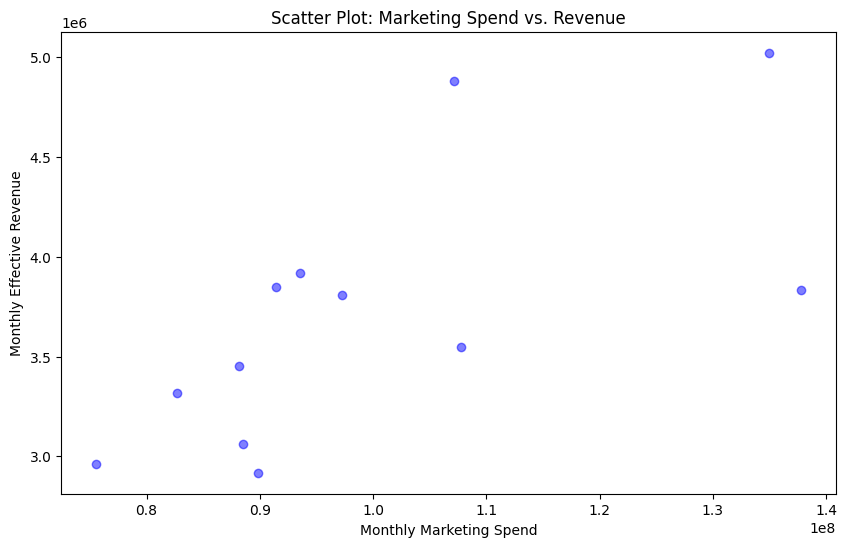

In [ ]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(monthly_totals['Online_Spend'], monthly_totals['Effective_Revenue'], c='blue', alpha=0.5)

# Add labels and a title
plt.xlabel('Monthly Marketing Spend')
plt.ylabel('Monthly Effective Revenue')
plt.title('Scatter Plot: Marketing Spend vs. Revenue')

# Show the plot
plt.show()


### Which product was appeared in the transactions?


In [ ]:
unique_products = merged_data['Product_SKU'].unique()
print(unique_products)


['GGOENEBJ079499' 'GGOEGFKQ020399' 'GGOEGAAB010516' ... 'GGOEGAWH062048'

 'GGOEGAEB091118' 'GGOEGOCJ093999']


### Which product was purchased mostly based on the quantity?

In [ ]:
# Group the data by 'Product_SKU' and sum the quantities
product_quantity = merged_data.groupby('Product_SKU')['Quantity'].sum().reset_index()

# Sort the products by quantity in descending order
product_quantity_sorted = product_quantity.sort_values(by='Quantity', ascending=False)

# Get the product with the highest quantity sold
most_purchased_product = product_quantity_sorted.iloc[0]

print("Product with the highest quantity sold:")
print(most_purchased_product)


Product with the highest quantity sold:

Product_SKU    GGOEGGOA017399

Quantity               194808

Name: 914, dtype: object


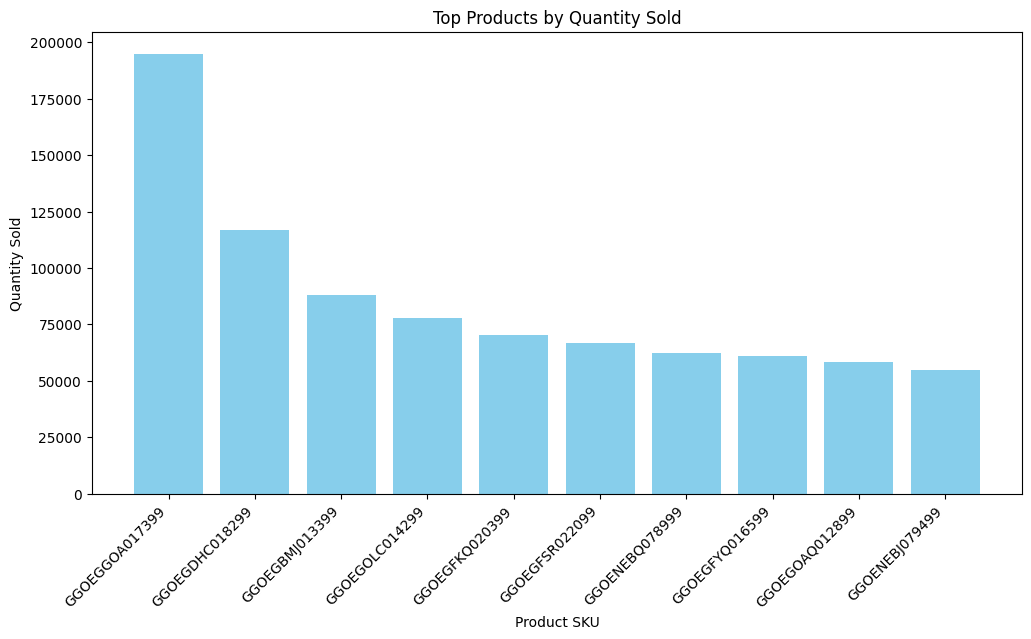

In [ ]:
# Group the data by 'Product_SKU' and sum the quantities
product_quantity = merged_data.groupby('Product_SKU')['Quantity'].sum().reset_index()

# Sort the products by quantity in descending order
product_quantity_sorted = product_quantity.sort_values(by='Quantity', ascending=False)

# Get the top N products with the highest quantity sold (for example, top 10)
top_n = 10
top_products = product_quantity_sorted.head(top_n)

# Create a bar chart to visualize the top N products
plt.figure(figsize=(12, 6))
plt.bar(top_products['Product_SKU'], top_products['Quantity'], color='skyblue')
plt.xlabel('Product SKU')
plt.ylabel('Quantity Sold')
plt.title('Top Products by Quantity Sold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


## 3. Performing Customer Segmentation

## Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver, Standard customers and define strategy on the same.

In [ ]:
import pandas as pd
import datetime as dt

# Calculate Recency, Frequency, and Monetary values
current_date = max(merged_data['Transaction_Date'])  # Replace with your current date

rfm = merged_data.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (current_date - x.max()).days,  # Recency
    'CustomerID': 'count',  # Frequency
    'Effective_Revenue': 'sum'  # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# RFM scoring
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])

def r_score(x):
    if x <= quantiles['Recency'][0.25]:
        return 4
    elif x <= quantiles['Recency'][0.50]:
        return 3
    elif x <= quantiles['Recency'][0.75]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quantiles[c][0.25]:
        return 1
    elif x <= quantiles[c][0.50]:
        return 2
    elif x <= quantiles[c][0.75]:
        return 3
    else:
        return 4

rfm['R'] = rfm['Recency'].apply(r_score)
rfm['F'] = rfm['Frequency'].apply(fm_score, args=('Frequency',))
rfm['M'] = rfm['Monetary'].apply(fm_score, args=('Monetary',))

# Combine the R, F, and M scores into a single RFM segment
rfm['RFM_Segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

# Define your RFM segments and strategies
segment_mapping = {
    '444': 'Premium',
    '311': 'Gold',
    '144': 'Silver',
    '111': 'Standard'
}

rfm['Segment'] = rfm['RFM_Segment'].map(segment_mapping)

# Display the resulting DataFrame
print(rfm.head())


            Recency  Frequency    Monetary  R  F  M RFM_Segment Segment

CustomerID                                                             

12346           107         24     297.504  3  1  1         311    Gold

12347            59        709  132600.192  3  4  4         344     NaN

12348            73        276   13844.352  3  3  2         332     NaN

12350            17        204   13056.672  4  2  2         422     NaN

12356           107        432   13847.712  3  3  2         332     NaN


In [ ]:
merged_data.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months', 'Coupon_Code', 'Discount_pct', 'Date', 'Offline_Spend',
       'Online_Spend', 'GST', 'Month', 'Invoice_Value', 'YearMonth',
       'Discount_Amount', 'Effective_Revenue', 'DayOfWeek'],
      dtype='object')

### Scientific (Using K-Means) & Understand the profiles. Define strategy for each segment.

   CustomerID  Recency  Frequency    Monetary

0       12346      107         24     297.504

1       12347       59        709  132600.192

2       12348       73        276   13844.352

3       12350       17        204   13056.672

4       12356      107        432   13847.712


C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

  warnings.warn(

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

  warnings.warn(

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

  warnings.warn(

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on 

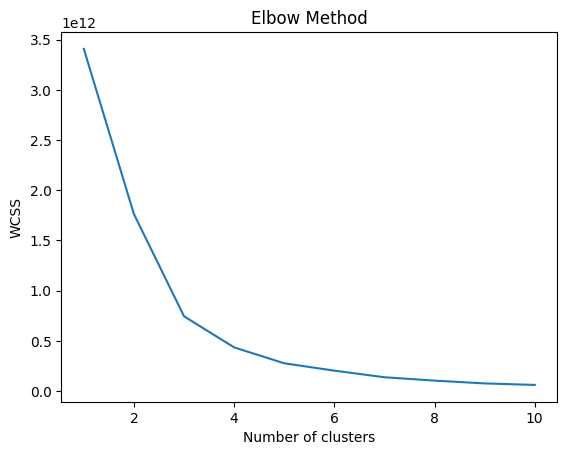

In [ ]:
# Calculate Recency, Frequency, and Monetary values
import pandas as pd

# Calculate the latest transaction date
latest_transaction_date = merged_data['Transaction_Date'].max()

# Create a new DataFrame with RFM values
rfm_data = merged_data.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (latest_transaction_date - x.max()).days,
    'Transaction_ID': 'count',
    'Effective_Revenue': 'sum'
}).reset_index()

# Rename the columns to match RFM
rfm_data.rename(columns={
    'Transaction_Date': 'Recency',
    'Transaction_ID': 'Frequency',
    'Effective_Revenue': 'Monetary'
}, inplace=True)

# Display the RFM DataFrame
print(rfm_data.head())

# Now, let's perform K-Means clustering using these features
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select relevant features
X = rfm_data[['Recency', 'Frequency', 'Monetary']]

# Determine the optimal number of clusters (K) using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method to find the optimal K
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


## 4. Predicting Customer Lifetime Value (Low Value/Medium Value/High Value)
 First define dependent variable with categories low value, medium value, high value
using customer revenue.


 Then perform Classification model


In [ ]:

# Merge the RFM data with the original dataset based on 'CustomerID'
merged_data = pd.merge(merged_data, rfm_data, on='CustomerID')

# Now, merged_data will contain the 'Recency', 'Frequency', and 'Monetary' columns

In [ ]:
# Define your own CLV categories based on revenue thresholds
low_value_threshold = 1000
high_value_threshold = 5000

def categorize_clv(revenue):
    if revenue < low_value_threshold:
        return 'Low Value'
    elif revenue < high_value_threshold:
        return 'Medium Value'
    else:
        return 'High Value'

merged_data['CLV_Category'] = merged_data['Effective_Revenue'].apply(categorize_clv)


In [ ]:
# Select features and target variable
X = merged_data[['Recency', 'Frequency', 'Monetary']]
y = merged_data['CLV_Category']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Random Forest Classifier (you can use other classifiers as well)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9977802089774691


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support



  High Value       0.00      0.00      0.00        87

   Low Value       1.00      1.00      1.00    125858

Medium Value       0.00      0.00      0.00       193



    accuracy                           1.00    126138

   macro avg       0.33      0.33      0.33    126138

weighted avg       1.00      1.00      1.00    126138




C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


## 5. Cross-Selling (Which products are selling together)
 You can perform exploratory analysis & market basket analysis to understand which
of items can be bundled together

In [ ]:
!pip install mlxtend


Defaulting to user installation because normal site-packages is not writeable




















In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Assuming the dataframe is named Online_Sales_df for Online_Sales data

# Create a basket dataframe with Quantity for each 'Product_Category' per Transaction_ID
basket = (merged_data.groupby(['Transaction_ID',  'Product_Category'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Transaction_ID'))

# Convert the units to 1 hot encoded values
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

# Generate frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

# Generate rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Now, rules contain your association rules for cross-selling.
# You can sort and view the rules as follows:
rules.sort_values(['confidence', 'lift'], ascending =[False, False])


# Now, rules contain your association rules for cross-selling.
# You can sort and view the rules as follows:
rules.sort_values(['confidence', 'lift'], ascending =[False, False])


C:\Users\rishi\AppData\Roaming\Python\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type

  warnings.warn(


antecedents             consequents  antecedent support  \
63       (Bags, Lifestyle)                (Office)            0.014963   
57       (Bags, Drinkware)                (Office)            0.021707   
70  (Drinkware, Lifestyle)                (Office)            0.025857   
5               (Headgear)               (Apparel)            0.026894   
24  (Notebooks & Journals)                (Office)            0.024740   
..                     ...                     ...                 ...   
53               (Apparel)     (Office, Lifestyle)            0.324369   
41               (Apparel)  (Drinkware, Lifestyle)            0.324369   
35               (Apparel)          (Bags, Office)            0.324369   
29               (Apparel)       (Bags, Drinkware)            0.324369   
9                (Apparel)  (Notebooks & Journals)            0.324369   

    consequent support   support  confidence      lift  leverage  conviction  \
63            0.140697  0.010175    0.680000  4.833091  0.008070    2.685323   
57            0.140697  0.014285    0.658088  4.677354  0.011231    2.513231   
70            0.140697  0.016719    0.646605  4.595736  0.013081    2.431566   
5             0.324369  0.017318    0.643917  1.985140  0.008594    1.897398   
24            0.140697  0.013846    0.559677  3.977900  0.010365    1.951531   
..                 ...       ...         ...       ...       ...         ...   
53            0.035114  0.017078    0.052651  1.499417  0.005688    1.018511   
41            0.025857  0.013567    0.041826  1.617578  0.005180    1.016666   
35            0.026336  0.012210    0.037643  1.429351  0.003668    1.011750   
29            0.021707  0.010694    0.032968  1.518788  0.003653    1.011645   
9             0.024740  0.010614    0.032722  1.322669  0.002589    1.008253   

    zhangs_metric  
63       0.805141  
57       0.803649  
70       0.803175  
5        0.509973  
24       0.767601  
..            ...  
53       0.492982  
41       0.565089  
35       0.444594  
29       0.505572  
9        0.361074  

[74 rows x 10 columns]

In [ ]:
print(rules.sort_values(['confidence', 'lift'], ascending=[False, False]))


               antecedents             consequents  antecedent support  \

63       (Bags, Lifestyle)                (Office)            0.014963   

57       (Bags, Drinkware)                (Office)            0.021707   

70  (Drinkware, Lifestyle)                (Office)            0.025857   

5               (Headgear)               (Apparel)            0.026894   

24  (Notebooks & Journals)                (Office)            0.024740   

..                     ...                     ...                 ...   

53               (Apparel)     (Office, Lifestyle)            0.324369   

41               (Apparel)  (Drinkware, Lifestyle)            0.324369   

35               (Apparel)          (Bags, Office)            0.324369   

29               (Apparel)       (Bags, Drinkware)            0.324369   

9                (Apparel)  (Notebooks & Journals)            0.324369   



    consequent support   support  confidence      lift  leverage  conviction  \

63            0.1

In [ ]:
print(frequent_itemsets)

     support                         itemsets

0   0.324369                        (Apparel)

1   0.061650                           (Bags)

2   0.010295                        (Bottles)

3   0.100714                      (Drinkware)

4   0.026894                       (Headgear)

5   0.068313                      (Lifestyle)

6   0.078768                           (Nest)

7   0.010295                    (Nest-Canada)

8   0.463908                       (Nest-USA)

9   0.024740           (Notebooks & Journals)

10  0.140697                         (Office)

11  0.017637                           (Waze)

12  0.025657                  (Apparel, Bags)

13  0.045010             (Apparel, Drinkware)

14  0.017318              (Apparel, Headgear)

15  0.033079             (Apparel, Lifestyle)

16  0.014604              (Apparel, Nest-USA)

17  0.010614  (Notebooks & Journals, Apparel)

18  0.062128                (Apparel, Office)

19  0.021707                (Bags, Drinkware)

20  0.014963 

In [ ]:
print(rules)


               antecedents             consequents  antecedent support  \

0                (Apparel)                  (Bags)            0.324369   

1                   (Bags)               (Apparel)            0.061650   

2                (Apparel)             (Drinkware)            0.324369   

3              (Drinkware)               (Apparel)            0.100714   

4                (Apparel)              (Headgear)            0.324369   

..                     ...                     ...                 ...   

69     (Office, Drinkware)             (Lifestyle)            0.046287   

70  (Drinkware, Lifestyle)                (Office)            0.025857   

71                (Office)  (Drinkware, Lifestyle)            0.140697   

72             (Lifestyle)     (Office, Drinkware)            0.068313   

73             (Drinkware)     (Office, Lifestyle)            0.100714   



    consequent support   support  confidence      lift  leverage  conviction  \

0             0.0

## Predicting Next Purchase Day(How soon each customer can visit the store (0-30 days, 30-60 days, 60-90 days, 90+ days)
### For this, we need create dependent variable at customer level (average days per one transaction for only repeat customers and divide into groups 0-30 days, 30-60 days, 60-90 days and 90+ days) then build classification model to predict next purchase of given customer.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Convert Transaction_Date to datetime format
merged_data['Transaction_Date'] = pd.to_datetime(merged_data['Transaction_Date'])

# Calculate average days per one transaction for each customer
# transaction_days = merged_data.groupby('CustomerID')['Transaction_Date'].apply(lambda dates: (dates.max() - dates.min()).days / len(dates))

# Define dependent variable with categories 0-30 days, 30-60 days, 60-90 days, 90+ days using average transaction days
# bins = [0, 30, 60, 90, float('inf')]
# labels = ['0-30 days', '30-60 days', '60-90 days', '90+ days']
# transaction_days_categories = pd.cut(transaction_days, bins=bins, labels=labels)

# # Add this as a new column to your dataframe
# merged_data = merged_data.merge(transaction_days_categories.rename('Next_Purchase_Day'), left_on='CustomerID', right_index=True)



merged_data['Next_Purchase_Day'] = merged_data.groupby('CustomerID')['Transaction_Date'].diff().dt.days
merged_data['Next_Purchase_Day'].fillna(0, inplace=True)

# Define the criteria for categorizing 'Next_Purchase_Day'
next_purchase_bins = [0, 30, 60, 90, np.inf]
next_purchase_labels = ['0-30 days', '30-60 days', '60-90 days', '90+ days']

# Create categorical bins based on the criteria
merged_data['Next_Purchase_Group'] = pd.cut(merged_data['Next_Purchase_Day'], bins=next_purchase_bins, labels=next_purchase_labels)




# Select your independent variables and target variable
X = merged_data[['Quantity', 'Avg_Price', 'Delivery_Charges',]] # replace these with your actual independent variables
y = merged_data['Next_Purchase_Day']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize a classifier
clf = RandomForestClassifier(random_state=1)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Now you can use clf to predict Next_Purchase_Day for new data

RandomForestClassifier(random_state=1)

In [ ]:
selected_columns = merged_data[['Next_Purchase_Day_x', 'Next_Purchase_Day_y', 'Next_Purchase_Day_x', 'Next_Purchase_Group', 'Next_Purchase_Day_y', 'Next_Purchase_Day', 'Predicted_Next_Purchase_Day']]
# print(selected_columns)
selected_columns.head()

Next_Purchase_Day_x  Next_Purchase_Day_x Next_Purchase_Day_y  \
0            0-30 days                  0.0           0-30 days   
1            0-30 days                  0.0           0-30 days   
2            0-30 days                  0.0           0-30 days   
3            0-30 days                  0.0           0-30 days   
4            0-30 days                  0.0           0-30 days   

  Next_Purchase_Day_y  Next_Purchase_Day_x  Next_Purchase_Day_x  \
0           0-30 days            0-30 days                  0.0   
1           0-30 days            0-30 days                  0.0   
2           0-30 days            0-30 days                  0.0   
3           0-30 days            0-30 days                  0.0   
4           0-30 days            0-30 days                  0.0   

  Next_Purchase_Group Next_Purchase_Day_y Next_Purchase_Day_y  \
0                 NaN           0-30 days           0-30 days   
1                 NaN           0-30 days           0-30 days   
2                 NaN           0-30 days           0-30 days   
3                 NaN           0-30 days           0-30 days   
4                 NaN           0-30 days           0-30 days   

   Next_Purchase_Day  Predicted_Next_Purchase_Day  
0                0.0                          0.0  
1                0.0                          0.0  
2                0.0                          0.0  
3                0.0                          0.0  
4                0.0                          0.0

In [ ]:
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support



         0.0       1.00      1.00      1.00    125785

         1.0       1.00      0.00      0.00        79

         2.0       1.00      0.00      0.00         6

         3.0       1.00      0.00      0.00         3

         4.0       1.00      0.00      0.00         6

         5.0       1.00      0.00      0.00         2

         6.0       1.00      0.00      0.00         2

         7.0       1.00      0.00      0.00         5

         8.0       1.00      0.00      0.00         1

         9.0       1.00      0.00      0.00         4

        10.0       1.00      0.00      0.00         5

        11.0       1.00      0.00      0.00         5

        12.0       1.00      0.00      0.00         2

        13.0       1.00      0.00      0.00         2

        14.0       1.00      0.00      0.00         6

        15.0       1.00      0.00      0.00         5

        16.0       1.00      0.00      0.00         5

        

## 7. Perform cohort analysis by defining below cohorts
 Customers who started in each month and understand their behaviour


 Which Month cohort has maximum retention?

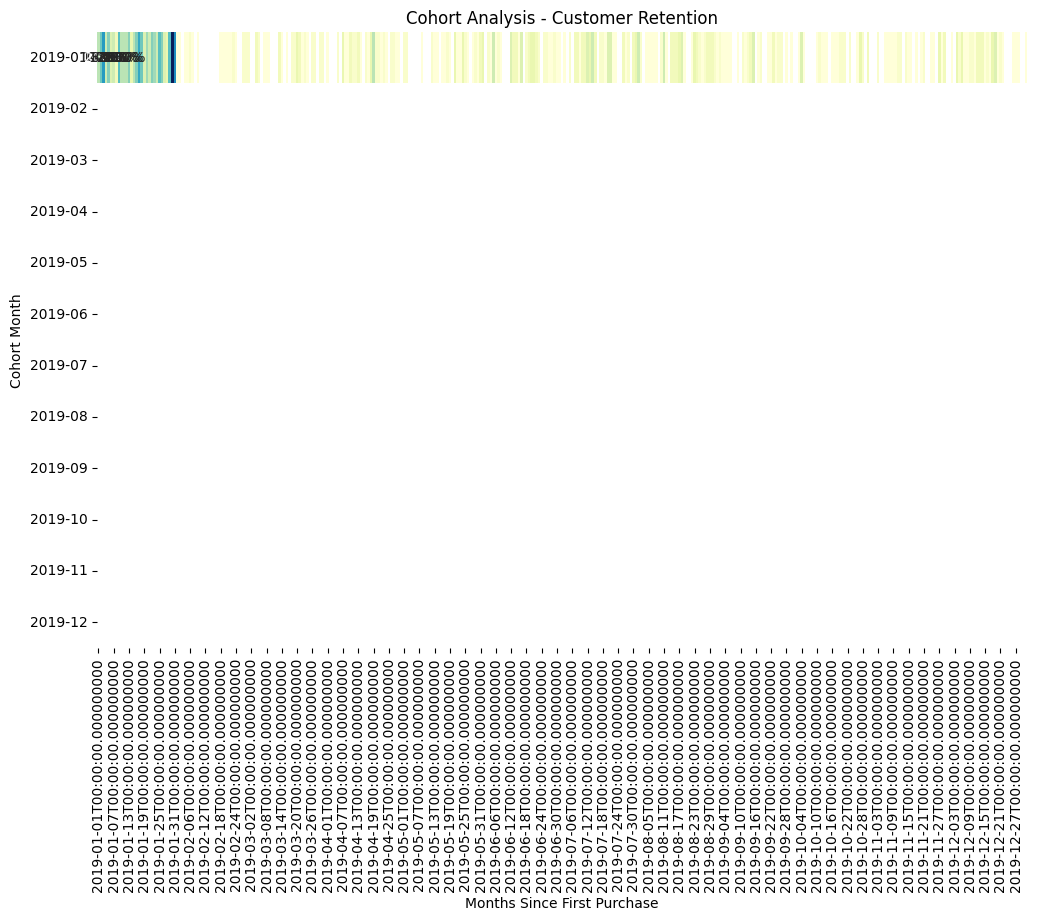

Cohort with Maximum Retention: First_Purchase_Month

2019-01   2019-01-30

2019-02          NaT

2019-03          NaT

2019-04          NaT

2019-05          NaT

2019-06          NaT

2019-07          NaT

2019-08          NaT

2019-09          NaT

2019-10          NaT

2019-11          NaT

2019-12          NaT

Freq: M, dtype: datetime64[ns]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'merged_data'
# Convert 'Transaction_Date' to a datetime object
merged_data['Transaction_Date'] = pd.to_datetime(merged_data['Transaction_Date'])

# Extract the month and year of the first purchase for each customer
merged_data['First_Purchase_Month'] = merged_data.groupby('CustomerID')['Transaction_Date'].transform('min').dt.to_period('M')

# Calculate the number of active customers for each cohort in each subsequent month
cohort_data = merged_data.groupby(['First_Purchase_Month', 'Transaction_Date']).agg({'CustomerID': pd.Series.nunique}).reset_index()

# Pivot the data to create a cohort table
cohort_table = cohort_data.pivot_table(index='First_Purchase_Month', columns='Transaction_Date', values='CustomerID')

# Calculate the retention rate for each cohort
cohort_size = cohort_table.iloc[:, 0]
retention = cohort_table.divide(cohort_size, axis=0)

# Visualize the cohort analysis results (heatmap)
plt.figure(figsize=(12, 8))
plt.title('Cohort Analysis - Customer Retention')
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu', cbar=False)
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.show()

# Identify the cohort with the maximum retention
max_retention_cohort = retention.idxmax(axis=1)
print("Cohort with Maximum Retention:", max_retention_cohort)
